# Final Project: Multi-Agent Pac-Men Challenge


## Final Project Progress 1

### **Scenario**
- Environment: Classic Pac-Man maze (grid with walls, pellets, and power pellets).

- Agents: 3 Pac-Man players (autonomous agents, not ghosts). Each has a goal to collect points by eating pellets and staying alive.

- Conflict: Certain critical routes (corridors) must be shared. If two or more agents attempt to take the same corridor simultaneously, they clash and one may be forced to wait or reroute.

- Challenge: Agents must negotiate rights of way or synchronize traversal of shared routes to stay in the game.

### **Required Features**
1. **Environment**

    - Maze grid with walls, pellets, and “shared route” corridors.

    - Pac-Men can move up, down, left, right (no diagonal).

2. **Agents**

    - Each agent has an energy bar or score counter.

    - They collect pellets for points.

    - If they fail to resolve conflicts properly, they “stall” or lose points.

3. **Negotiation & Conflict Resolution**

    - When two or more agents want the same corridor at the same time:

    - Negotiation: Agents propose who goes first (e.g., based on score, random lottery, or alternating offers).

    - Conflict Resolution: If no agreement, apply fallback (priority rule, penalty, or random arbitration).

4. **Synchronization**

    - If multiple agents need to coordinate traversal (e.g., crossing intersection), they can synchronize by token passing or barrier synchronization.

5. **Win/Survival Condition**

    - Agents must keep collecting pellets while resolving conflicts.

    - An agent “drops out” if it repeatedly fails to negotiate or loses too much energy.

    - Winner is the one with the highest score after all pellets are consumed or a time limit ends.

### **Metrics to Record**

- Number of conflicts detected.

- Number of successful negotiations.

- Average waiting time per agent.

- Fairness in access to shared routes.

- Total score per agent.



In [ ]:
## Text-based Pagcman Simulation with Multi-Agent Negotiation

import random
import time
from collections import defaultdict
import math

# ====================== Environment Setup ======================

class Maze:
    def __init__(self, width=10, height=10):
        self.width = width
        self.height = height
        self.grid = [['.' for _ in range(width)] for _ in range(height)]
        self.shared_corridors = set()
        self.walls = set()
        self.pellets = set()
        self._generate_maze()

    def _generate_maze(self):
        # Create simple walls and shared corridors
        for _ in range(int(self.width * self.height * 0.1)):
            wall = (random.randint(0, self.height - 1), random.randint(0, self.width - 1))
            self.grid[wall[0]][wall[1]] = '#'
            self.walls.add(wall)

        for _ in range(int(self.width * self.height * 0.15)):
            shared = (random.randint(0, self.height - 1), random.randint(0, self.width - 1))
            if shared not in self.walls:
                self.grid[shared[0]][shared[1]] = '='
                self.shared_corridors.add(shared)

        for i in range(self.height):
            for j in range(self.width):
                if self.grid[i][j] == '.':
                    self.pellets.add((i, j))

    def display(self, agents):
        grid_copy = [row[:] for row in self.grid]
        for agent in agents:
            x, y = agent.pos
            grid_copy[x][y] = agent.symbol
        for row in grid_copy:
            print(' '.join(row))
        print()

# ====================== Agent Setup ======================

class Agent:
    def __init__(self, name, symbol, pos, energy=100):
        self.name = name
        self.symbol = symbol
        self.pos = pos
        self.energy = energy
        self.score = 0
        self.wait_time = 0
        self.failed_negotiations = 0
        self.active = True
        self.negotiation_history = []  # For learning strategies
        self.learning_rate = 0.1  # Simple learning parameter

    def move(self, direction, maze):
        x, y = self.pos
        dx, dy = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}.get(direction, (0, 0))
        nx, ny = x + dx, y + dy

        # Boundary and wall check
        if 0 <= nx < maze.height and 0 <= ny < maze.width and (nx, ny) not in maze.walls:
            return (nx, ny)
        return self.pos

    def update_energy(self, delta):
        self.energy += delta
        if self.energy < 0:
            self.energy = 0

    def learn_from_negotiation(self, success, opponent, issue):
        # Simple reinforcement learning: adjust strategy based on outcome
        self.negotiation_history.append((success, opponent, issue))
        if success:
            # Increase confidence in similar situations
            pass  # Could be extended with more complex learning

    def make_multi_issue_proposal(self, opponents, maze):
        # Multi-issue negotiation: propose trade-offs
        # For example, offer to yield corridor access in exchange for future pellet sharing
        if not opponents:
            return None
        opponent = random.choice(opponents)
        # Simple proposal: offer to wait if opponent shares pellets later
        proposal = {
            'type': 'trade',
            'offer': 'yield_corridor',
            'request': 'share_pellets',
            'from': self.name,
            'to': opponent.name
        }
        return proposal

# ====================== Ghost Setup ======================

class Ghost:
    def __init__(self, name, symbol, pos):
        self.name = name
        self.symbol = symbol
        self.pos = pos
        self.active = True

    def move(self, maze, agents):
        # Simple ghost movement: chase nearest agent or random
        x, y = self.pos
        directions = ['U', 'D', 'L', 'R']
        random.shuffle(directions)
        
        # Try to move towards the nearest agent
        best_dir = None
        min_dist = float('inf')
        for dir in directions:
            dx, dy = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}[dir]
            nx, ny = x + dx, y + dy
            if 0 <= nx < maze.height and 0 <= ny < maze.width and (nx, ny) not in maze.walls:
                # Check distance to nearest active agent
                for agent in agents:
                    if agent.active:
                        dist = math.sqrt((nx - agent.pos[0])**2 + (ny - agent.pos[1])**2)
                        if dist < min_dist:
                            min_dist = dist
                            best_dir = (nx, ny)
        if best_dir:
            return best_dir
        # Fallback to random move
        for dir in directions:
            dx, dy = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}[dir]
            nx, ny = x + dx, y + dy
            if 0 <= nx < maze.height and 0 <= ny < maze.width and (nx, ny) not in maze.walls:
                return (nx, ny)
        return self.pos

# ====================== Negotiation & Conflict Handling ======================

class ConflictManager:
    def __init__(self):
        self.conflicts = 0
        self.successful_negotiations = 0
        self.waiting_times = defaultdict(int)
        self.multi_issue_negotiations = 0

    def negotiate(self, agents, proposed_positions):
        reverse_map = defaultdict(list)
        for agent, pos in proposed_positions.items():
            reverse_map[pos].append(agent)

        resolved_positions = {}
        for pos, contenders in reverse_map.items():
            if len(contenders) == 1:
                resolved_positions[contenders[0]] = pos
            else:
                # Conflict detected
                self.conflicts += 1
                # Try multi-issue negotiation first
                if self.multi_issue_negotiate(contenders, pos):
                    self.multi_issue_negotiations += 1
                    # If multi-issue succeeds, all agents agree on a resolution
                    # For now, use simple resolution if multi-issue fails
                    winner = self.resolve_conflict(contenders)
                else:
                    winner = self.resolve_conflict(contenders)
                self.successful_negotiations += 1
                for agent in contenders:
                    if agent == winner:
                        resolved_positions[agent] = pos
                    else:
                        self.waiting_times[agent.name] += 1
                        resolved_positions[agent] = agent.pos
                        agent.wait_time += 1
        return resolved_positions

    def resolve_conflict(self, contenders):
        # Simple resolution: higher score wins, else random
        contenders.sort(key=lambda a: (a.score, a.energy), reverse=True)
        top = [a for a in contenders if a.score == contenders[0].score]
        return random.choice(top)

    def multi_issue_negotiate(self, contenders, pos):
        # Attempt multi-issue negotiation among contenders
        # For example, agents can trade corridor access for pellet sharing
        if len(contenders) < 2:
            return False

        # Randomly select two agents to negotiate
        agents_to_negotiate = random.sample(contenders, min(2, len(contenders)))
        agent1, agent2 = agents_to_negotiate[0], agents_to_negotiate[1]

        # Agent1 makes a proposal
        proposal = agent1.make_multi_issue_proposal([agent2], None)  # Maze not needed for now
        if proposal and random.random() < 0.5:  # 50% chance of acceptance for simplicity
            # For now, assume proposal is accepted: agent1 yields to agent2
            # In a real system, this would involve more complex logic
            agent1.learn_from_negotiation(True, agent2, 'corridor_access')
            agent2.learn_from_negotiation(True, agent1, 'corridor_access')
            return True
        return False

# ====================== Simulation Logic ======================

class PacmanSimulation:
    def __init__(self):
        self.maze = Maze()
        self.agents = [
            Agent("PacmanA", "A", (0, 0)),
            Agent("PacmanB", "B", (9, 0)),
            Agent("PacmanC", "C", (0, 9))
        ]
        self.ghosts = [
            Ghost("Ghost1", "G", (5, 5)),
            Ghost("Ghost2", "H", (5, 4))
        ]
        self.manager = ConflictManager()
        self.turns = 50

    def run(self):
        token_holder = 0  # Token passing for synchronization
        active_agents = self.agents.copy()
        
        for t in range(self.turns):
            print(f"===== Turn {t+1} =====")
            
            # Check win/loss conditions
            if len(self.maze.pellets) == 0:
                print("All pellets collected! Game over.")
                break
                
            active_agents = [a for a in active_agents if a.energy > 0 and a.active]
            if len(active_agents) == 0:
                print("All agents have dropped out!")
                break
            elif len(active_agents) == 1:
                print(f"Only {active_agents[0].name} remains!")
                break

            # Ghosts move
            for ghost in self.ghosts:
                if ghost.active:
                    new_pos = ghost.move(self.maze, active_agents)
                    ghost.pos = new_pos
                    # Check if ghost caught any agent
                    for agent in active_agents:
                        if agent.pos == ghost.pos and agent.active:
                            agent.update_energy(-20)  # Significant energy loss when caught
                            print(f"{agent.name} was caught by {ghost.name}! Energy reduced.")
                            if agent.energy <= 0:
                                agent.active = False
                                print(f"{agent.name} has dropped out due to ghost attack!")

            proposed_positions = {}
            for idx, agent in enumerate(active_agents):
                if not agent.active:
                    continue
                    
                # Only the token holder can propose a move in a shared corridor this turn
                if agent.pos in self.maze.shared_corridors:
                    if idx == token_holder:
                        direction = random.choice(['U', 'D', 'L', 'R'])
                        proposed_positions[agent] = agent.move(direction, self.maze)
                    else:
                        # Must wait for token
                        proposed_positions[agent] = agent.pos
                        agent.wait_time += 1
                else:
                    direction = random.choice(['U', 'D', 'L', 'R'])
                    proposed_positions[agent] = agent.move(direction, self.maze)

            resolved = self.manager.negotiate(active_agents, proposed_positions)
            for agent, pos in resolved.items():
                agent.pos = pos
                if pos in self.maze.pellets:
                    agent.score += 10
                    self.maze.pellets.remove(pos)
                    self.maze.grid[pos[0]][pos[1]] = ' '
                if pos in self.maze.shared_corridors:
                    agent.update_energy(-1)
                else:
                    agent.update_energy(-0.5)
                    
                # Check if agent should drop out
                if agent.energy <= 0:
                    agent.active = False
                    print(f"{agent.name} has dropped out due to low energy!")

            # Display the maze with agents and ghosts
            self.maze.display(active_agents + self.ghosts)
            time.sleep(0.1)

            # Token passing: next agent gets the token for shared corridor
            token_holder = (token_holder + 1) % len(active_agents)

        self.report_metrics()

    def report_metrics(self):
        print("\n===== Simulation Report =====")
        active_agents = [a for a in self.agents if a.active]
        
        if active_agents:
            winner = max(active_agents, key=lambda a: a.score)
            print(f"WINNER: {winner.name} with {winner.score} points!")
        
        for agent in self.agents:
            status = "ACTIVE" if agent.active else "DROPPED OUT"
            print(f"{agent.name}: Score={agent.score}, Energy={agent.energy}, WaitTime={agent.wait_time} [{status}]")
        
        print(f"Conflicts: {self.manager.conflicts}")
        print(f"Successful Negotiations: {self.manager.successful_negotiations}")
        print(f"Multi-issue Negotiations: {self.manager.multi_issue_negotiations}")
        
        active_count = len(active_agents)
        if active_count > 0:
            avg_wait = sum(a.wait_time for a in self.agents) / len(self.agents)
            print(f"Average Wait: {avg_wait:.2f}")
            
            # Fairness metric: Gini coefficient approximation
            scores = [a.score for a in self.agents if a.score > 0]
            if scores:
                mean_score = sum(scores) / len(scores)
                fairness = 1 - (sum(abs(s - mean_score) for s in scores) / (2 * len(scores) * mean_score)) if mean_score > 0 else 1
                print(f"Fairness Index: {fairness:.3f}")
        
        print("=============================")

# ====================== Entry Point ======================

if __name__ == "__main__":
    sim = PacmanSimulation()
    sim.run()

===== Turn 1 =====
A . . . . . . . . C
. # . . . . . . . .
. . # . . . . # . .
. . . . . = . . = .
. . . . . G . . . .
. = = H = . = . . .
. . . . . . . . = #
. # . # = = . . . .
. . . . = = . . . #
B . = . . . # . # .

===== Turn 2 =====
  . . . . . . . . C
A # . . . . . . . .
. . # . . . . # . .
. . . . . = . . = .
. . . . . . G . . .
. = = . = . = . . .
. . . H . . . . = #
. # . # = = . . . .
. . . . = = . . . #
B . = . . . # . # .

===== Turn 3 =====
  . . . . . . . . C
A # . . . . . . . .
. . # . . . . # . .
. . . . . = G . = .
. . . . . . . . . .
. = = . = . = . . .
. . H . . . . . = #
. # . # = = . . . .
. . . . = = . . . #
# B = . . . # . # .

===== Turn 4 =====
  . . . . . . . . C
A # . . . . . . . .
. . # . . . . # . .
. . . . . = . G = .
. . . . . . . . . .
. = = . = . = . . .
. . . . . . . . = #
. # H # = = . . . .
. . . . = = . . . #
# B = . . . # . # .

===== Turn 5 =====
  . . . . . . . . C
A # . . . . . . . .
. . # . . . . # . .
. . . . . = . . G .
. . . . . . . . . .
.

### **Extended Work (optional)**
- Add ghosts back into the game: agents must also synchronize/coordinate to avoid them.

- Multi-issue negotiation: trade route access in exchange for pellets in another area.

- Learning strategies: agents adapt their negotiation tactics over time.

In [ ]:
## Visualization using Pygame

import pygame
import sys
import os
from pacman_simulation import PacmanSimulation
import random

class PacmanVisualizer:
    def __init__(self, simulation, cell_size=50):
        self.simulation = simulation
        self.cell_size = cell_size
        self.width = simulation.maze.width * cell_size
        self.height = simulation.maze.height * cell_size
        
        # Initialize Pygame
        pygame.init()
        self.screen = pygame.display.set_mode((self.width, self.height))
        pygame.display.set_caption("Pac-Man Multi-Agent Simulation")
        
        # Colors
        self.colors = {
            'background': (0, 0, 0),
            'wall': (0, 0, 150),
            'pellet': (255, 255, 255),
            'shared_corridor': (100, 100, 255),
            'agent_a': (255, 0, 0),      # Red
            'agent_b': (0, 255, 0),      # Green  
            'agent_c': (255, 255, 0),    # Yellow
            'ghost': (255, 0, 255),      # Pink
            'text': (255, 255, 255)
        }
        
        # Font for displaying scores
        self.font = pygame.font.Font(None, 24)
        
    def draw_maze(self):
        """Draw the maze grid with walls, pellets, and shared corridors"""
        self.screen.fill(self.colors['background'])
        
        for i in range(self.simulation.maze.height):
            for j in range(self.simulation.maze.width):
                x = j * self.cell_size
                y = i * self.cell_size
                rect = pygame.Rect(x, y, self.cell_size, self.cell_size)
                
                # Draw different cell types
                if (i, j) in self.simulation.maze.walls:
                    pygame.draw.rect(self.screen, self.colors['wall'], rect)
                elif (i, j) in self.simulation.maze.shared_corridors:
                    pygame.draw.rect(self.screen, self.colors['shared_corridor'], rect)
                elif (i, j) in self.simulation.maze.pellets:
                    # Draw pellet as small circle
                    center = (x + self.cell_size // 2, y + self.cell_size // 2)
                    pygame.draw.circle(self.screen, self.colors['pellet'], center, self.cell_size // 8)
                
                # Draw grid lines
                pygame.draw.rect(self.screen, (50, 50, 50), rect, 1)
    
    def draw_agents(self):
        """Draw all active agents"""
        for agent in self.simulation.agents:
            if agent.active:
                x = agent.pos[1] * self.cell_size + self.cell_size // 2
                y = agent.pos[0] * self.cell_size + self.cell_size // 2
                
                # Different colors for different agents
                if agent.symbol == 'A':
                    color = self.colors['agent_a']
                elif agent.symbol == 'B':
                    color = self.colors['agent_b']
                else:
                    color = self.colors['agent_c']
                
                # Draw agent as circle
                pygame.draw.circle(self.screen, color, (x, y), self.cell_size // 3)
                
                # Draw agent symbol
                text = self.font.render(agent.symbol, True, (0, 0, 0))
                text_rect = text.get_rect(center=(x, y))
                self.screen.blit(text, text_rect)
    
    def draw_ghosts(self):
        """Draw all ghosts"""
        for ghost in self.simulation.ghosts:
            if ghost.active:
                x = ghost.pos[1] * self.cell_size + self.cell_size // 2
                y = ghost.pos[0] * self.cell_size + self.cell_size // 2
                
                # Draw ghost as larger circle
                pygame.draw.circle(self.screen, self.colors['ghost'], (x, y), self.cell_size // 2.5)
                
                # Draw ghost symbol
                text = self.font.render(ghost.symbol, True, (0, 0, 0))
                text_rect = text.get_rect(center=(x, y))
                self.screen.blit(text, text_rect)
    
    def draw_stats(self, turn):
        """Draw current turn and agent statistics"""
        stats_y = 10
        
        # Draw turn number
        turn_text = self.font.render(f"Turn: {turn}", True, self.colors['text'])
        self.screen.blit(turn_text, (10, stats_y))
        stats_y += 30
        
        # Draw agent stats
        for agent in self.simulation.agents:
            status = "ACTIVE" if agent.active else "DROPPED"
            text = f"{agent.name}: Score={agent.score}, Energy={agent.energy:.1f}"
            stat_text = self.font.render(text, True, self.colors['text'])
            self.screen.blit(stat_text, (10, stats_y))
            stats_y += 25
    
    def handle_events(self):
        """Handle Pygame events"""
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                return False
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_ESCAPE:
                    return False
        return True
    
    def run_visualization(self):
        """Run the simulation with visualization"""
        clock = pygame.time.Clock()
        running = True
        
        token_holder = 0
        active_agents = self.simulation.agents.copy()
        turn = 0
        
        while running and turn < self.simulation.turns:
            turn += 1
            
            # Handle events
            if not self.handle_events():
                break
            
            # Run one simulation step
            # Check win/loss conditions
            if len(self.simulation.maze.pellets) == 0:
                print("All pellets collected! Game over.")
                break
                
            active_agents = [a for a in active_agents if a.energy > 0 and a.active]
            if len(active_agents) == 0:
                print("All agents have dropped out!")
                break
            elif len(active_agents) == 1:
                print(f"Only {active_agents[0].name} remains!")
                break

            # Ghosts move
            for ghost in self.simulation.ghosts:
                if ghost.active:
                    new_pos = ghost.move(self.simulation.maze, active_agents)
                    ghost.pos = new_pos
                    # Check if ghost caught any agent
                    for agent in active_agents:
                        if agent.pos == ghost.pos and agent.active:
                            agent.update_energy(-20)
                            print(f"{agent.name} was caught by {ghost.name}! Energy reduced.")
                            if agent.energy <= 0:
                                agent.active = False
                                print(f"{agent.name} has dropped out due to ghost attack!")

            proposed_positions = {}
            for idx, agent in enumerate(active_agents):
                if not agent.active:
                    continue
                    
                # Only the token holder can propose a move in a shared corridor this turn
                if agent.pos in self.simulation.maze.shared_corridors:
                    if idx == token_holder:
                        direction = random.choice(['U', 'D', 'L', 'R'])
                        proposed_positions[agent] = agent.move(direction, self.simulation.maze)
                    else:
                        # Must wait for token
                        proposed_positions[agent] = agent.pos
                        agent.wait_time += 1
                else:
                    direction = random.choice(['U', 'D', 'L', 'R'])
                    proposed_positions[agent] = agent.move(direction, self.simulation.maze)

            resolved = self.simulation.manager.negotiate(active_agents, proposed_positions)
            for agent, pos in resolved.items():
                agent.pos = pos
                if pos in self.simulation.maze.pellets:
                    agent.score += 10
                    self.simulation.maze.pellets.remove(pos)
                    self.simulation.maze.grid[pos[0]][pos[1]] = ' '
                if pos in self.simulation.maze.shared_corridors:
                    agent.update_energy(-1)
                else:
                    agent.update_energy(-0.5)
                    
                # Check if agent should drop out
                if agent.energy <= 0:
                    agent.active = False
                    print(f"{agent.name} has dropped out due to low energy!")

            # Update visualization
            self.draw_maze()
            self.draw_agents()
            self.draw_ghosts()
            self.draw_stats(turn)
            
            pygame.display.flip()
            clock.tick(2)  # 2 FPS for better visibility
            
            # Token passing: next agent gets the token for shared corridor
            token_holder = (token_holder + 1) % len(active_agents)
        
        # Final metrics report
        self.simulation.report_metrics()
        
        # Keep window open until user closes it
        print("Simulation finished. Close the window to exit.")
        while running:
            if not self.handle_events():
                break
            pygame.time.wait(100)
        
        pygame.quit()

if __name__ == "__main__":
    # Check if Pygame is available
    try:
        sim = PacmanSimulation()
        visualizer = PacmanVisualizer(sim)
        visualizer.run_visualization()
    except ImportError:
        print("Pygame not available. Running in text mode...")
        sim = PacmanSimulation()
        sim.run()

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html
PacmanC was caught by Ghost1! Energy reduced.
PacmanC was caught by Ghost1! Energy reduced.
PacmanC was caught by Ghost1! Energy reduced.
PacmanC was caught by Ghost1! Energy reduced.
PacmanC has dropped out due to low energy!
PacmanA was caught by Ghost1! Energy reduced.
PacmanA was caught by Ghost1! Energy reduced.

===== Simulation Report =====
WINNER: PacmanA with 70 points!
PacmanA: Score=70, Energy=22.0, WaitTime=15 [ACTIVE]
PacmanB: Score=20, Energy=75.0, WaitTime=0 [ACTIVE]
PacmanC: Score=190, Energy=0.0, WaitTime=0 [DROPPED OUT]
Conflicts: 0
Successful Negotiations: 0
Multi-issue Negotiations: 0
Average Wait: 5.00
Fairness Index: 0.655
Simulation finished. Close the window to exit.


## **Project Progress 2 (Final)**

### **Next Steps: Conflict Detection and Protocol Implementation** 

### **Phase 1: Conflict Detection and Synchronization (Core Mechanism)**

    This phase establishes the when and how of resource contention.

1. **Refine the Environment and State**

    Your environment needs to manage the "lock" for the critical resource.

    1.1. Create Shared Route Status:

        - Modify your environment grid to explicitly track the status of each Shared Route Corridor. This can be a simple array or dictionary mapping the corridor ID to its state:

            - UNLOCKED (available)

            - LOCKED_BY_AGENT_A

    1.2. Implement the Mutual Exclusion Lock:

        - Create lock() and unlock() functions within the Environment/Referee Agent that agents must call before and after traversing a Shared Route.

        - If an agent attempts to lock() an already locked corridor, a Conflict Event is triggered.

2. **Implement Conflict Detection**

    Agents must anticipate and prevent collisions rather than just reacting to them.

    2.1. Path Anticipation:

        - After an agent runs its path-planning algorithm (BFS/A*), its planned path should include a check for the next Shared Route it intends to enter.

        - Implement an Agent.predict_next_move() function that looks 1-2 steps ahead.

    2.2. Conflict Pre-Detection (Local Sensing):

        - In the agent's perception loop, check if any other agent is currently occupying the target Shared Route or if another agent is within the defined sensing radius and also planning to enter the same Shared Route in the next 1-2 moves.

        - If a high-probability collision is detected, trigger the Negotiation/Conflict Event before the agent attempts to move into the route.

    2.3. Conflict Event Trigger:

        - Create an Environment.trigger_conflict(agent_A, agent_B, corridor_ID) function that pauses the normal movement of the involved agents and hands control over to the negotiation module.

### **Phase 2: Protocol Implementation and Comparison**

    This phase implements the two required strategies for your academic comparison.

3. Implement Negotiation Strategy 1: Priority-Based (Baseline)

    This is your control group. It is simple, deterministic, and highly efficient but likely unfair.

    3.1. Define the Priority Rule: Choose a single, deterministic rule for the baseline. A good choice is "Highest Score Wins" or "Lowest Health Wins."

    3.2. Implement the Fallback: When a conflict event is triggered, the system immediately compares the required metric (score or health).

    3.3. Action and Penalty:

        - The Winning Agent is granted the lock and proceeds.

        - The Losing Agent is forced into the WAIT state for a fixed number of turns (the efficiency cost) and incurs a minor penalty (e.g., -5 points) for the failed access attempt.

        - Log the waiting time and the outcome.

4. Implement Negotiation Strategy 2: Formal Protocol (Alternating Offers)
 

    This strategy requires structured communication and is the core of your MAS analysis.

    4.1. Define Message Structure:

        - Formalize the messages agents can exchange, including fields for: Sender ID, Receiver ID, Performative (e.g., PROPOSE, ACCEPT, REJECT), and Content (e.g., Access to Corridor C3 now, Wait for 2 turns).

    4.2. Implement the Alternating Offers Logic:

        - When a conflict is detected, the agent with the lower priority (e.g., based on arrival time) becomes the Proposer.

        - The Proposer sends a message: "I will go first, and you will wait 1 turn."

        - The Respondent (the other agent) evaluates the proposal based on a simple Utility Function (e.g., Is waiting 1 turn less costly than the penalty for a fallback?).

        - The Respondent can ACCEPT (leading to a successful negotiation) or REJECT (leading to the Respondent sending a counter-proposal).

    4.3. Implement Time-Out and Fallback:

        - Set a maximum number of rounds (e.g., 3) for the offers. If the limit is reached without an ACCEPT message, the negotiation fails.

        - The system applies the Conflict Resolution Fallback (random lottery or a fixed rule) and penalizes both agents heavily for inefficient negotiation (e.g., -15 points).

5. Data Logging
 
    - Crucially, ensure your code logs all required metrics immediately upon conflict resolution.

    - Log the Strategy Used, Conflict Time, Winning Agent, Waiting Time of Loser, Negotiation Rounds, and Final Outcome (Success/Fallback).

### **Create a final documentation woth this format:**

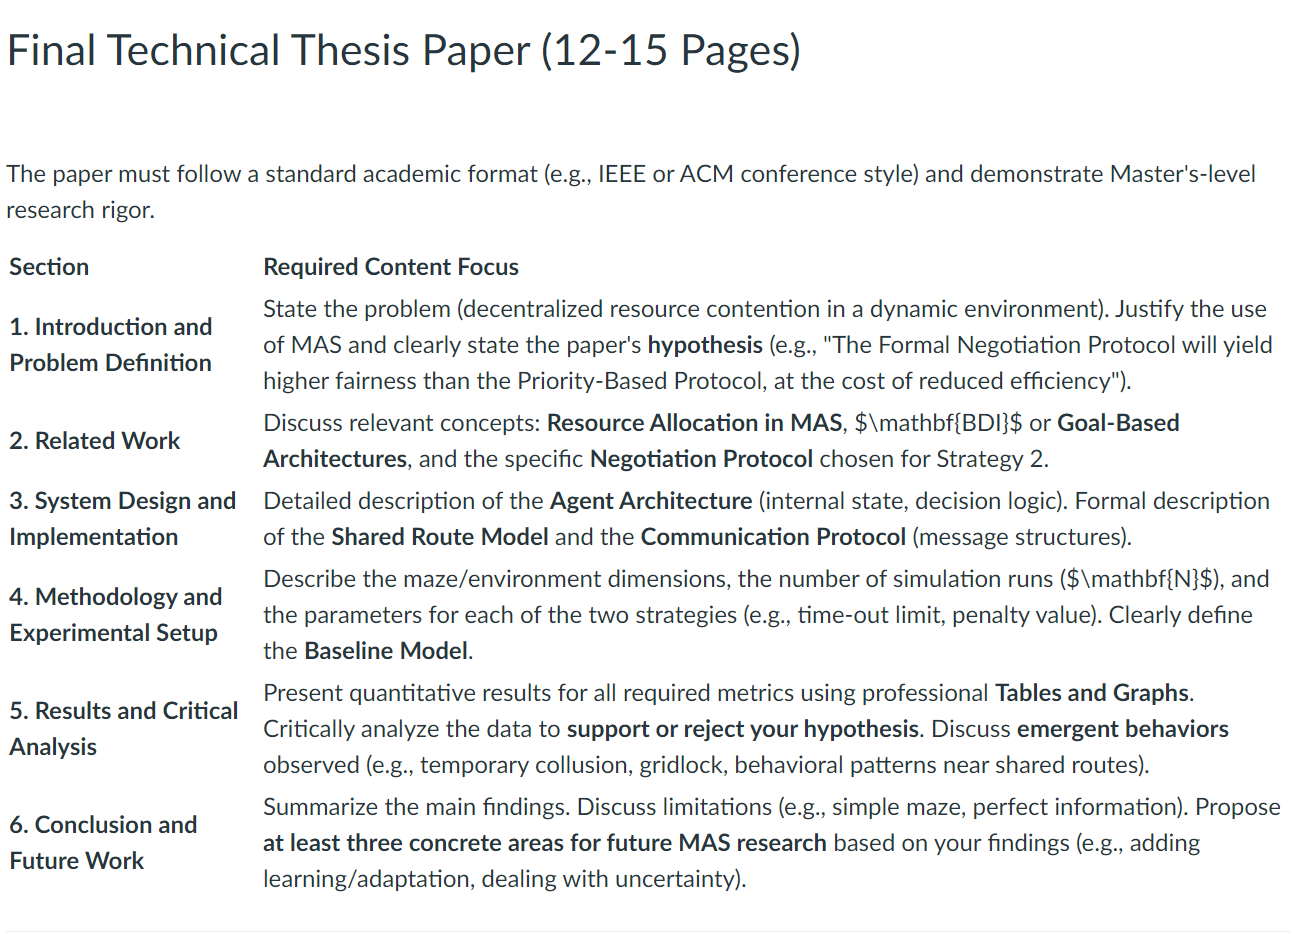

4. Submission Details and Rubric
 
    4.1. Code Repository Submission
 

        The final repository must be a shared, version-controlled repository (e.g., GitHub, GitLab) containing:

            - All simulation code and agent classes.

            - A clear README.md file explaining how to run the simulation and reproduce the results.

            - The raw simulation output data (e.g., CSV files) used to generate the paper's figures.

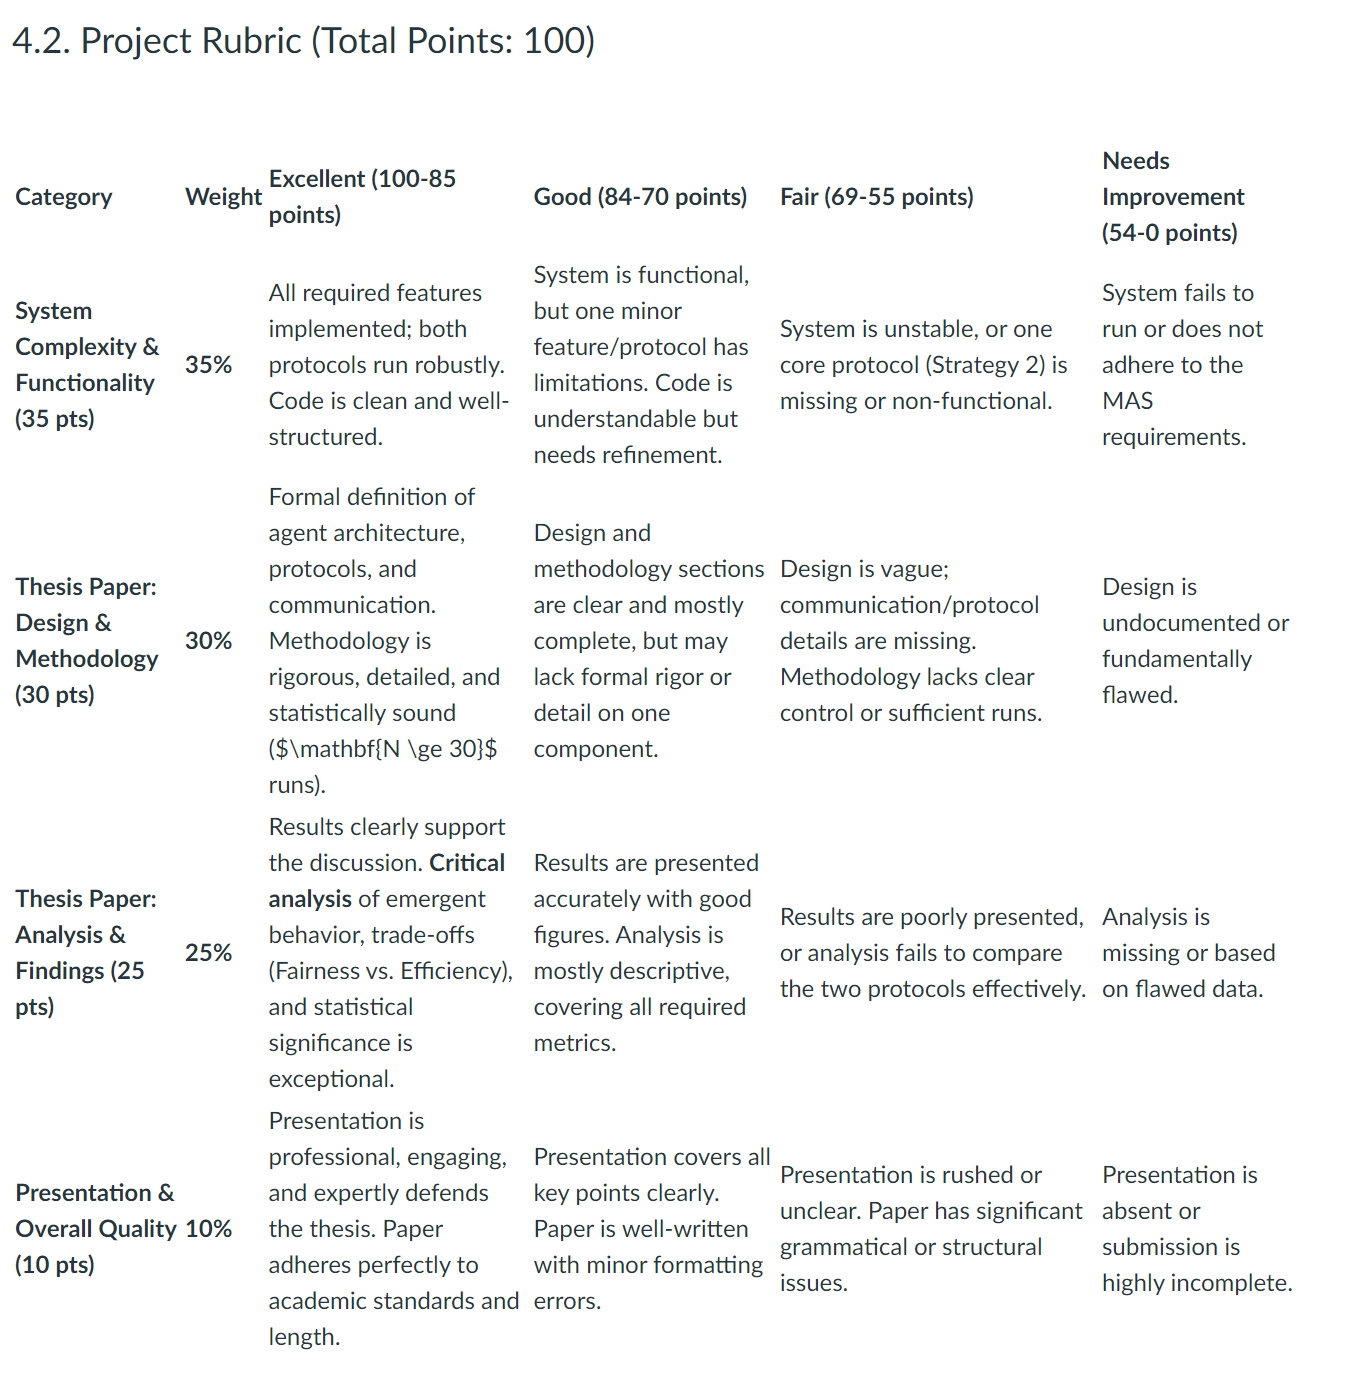

# End